In [1]:
# The bpnet pipeline saves the model as a .pb file. We have to convert this to an h5 file for compatibility with our pipeline
# import tensorflow as tf

# # Load the SavedModel
# model = tf.keras.models.load_model(model_path)

# # Convert and reset model_path
# model_path = f'{base_dir}/resources/model.h5'
# if hasattr(model, 'save'):
#     model.save(model_path)

# Run Pipeline

## Set Filepaths and Variables

In [1]:
# Base directory for all inputs / outputs
base_dir = f'/scratch/users/jgalante/SparseNet/p53'

# Paths to resources
peaks_bed = f"{base_dir}/resources/peaks_inliers.bed"
seqs = f'{base_dir}/resources/genome.fa'
signal_plus = f"{base_dir}/resources/experiment_plus.bw"
signal_minus = f"{base_dir}/resources/experiment_minus.bw"
ctl_plus = f"{base_dir}/resources/control_plus.bw"
ctl_minus = f"{base_dir}/resources/control_minus.bw"
negatives_bed = f"{base_dir}/resources/gc_negatives.bed"
model_path = f'{base_dir}/resources/model.h5'

# Output Directory
out_dir = f'{base_dir}/results'
pwm_root_dir = f"{out_dir}/pwms"

In [2]:
# Set variables
expansion_factor = 4.0
topk_fraction = 0.05
center_length = 1000
epochs = 3
inner_bs = 16384
lr = 1e-3

# pwm settings
num_samples_per_node = 1000
num_top_nodes = int(expansion_factor * 64)
latent_dim = int(expansion_factor * 64)

## Create Datasets

In [3]:
# Prepare training data and other information
import numpy
import os
import torch
from bpnetlite.io import PeakGenerator
from workflow.scripts.pipeline_scripts import deterministic_data_loaders as ddl
from workflow.scripts.pipeline_scripts import models as mds
from workflow.scripts.pipeline_scripts import SAE_trainer as st
from workflow.scripts.pipeline_scripts import save_activations as sa
from workflow.scripts.pipeline_scripts import plot_activation_frequencies as nf
from workflow.scripts.pipeline_scripts import create_PWM_for_nodes as pwm

training_data = PeakGenerator(
    peaks = peaks_bed,
    negatives = negatives_bed,
    sequences = seqs,
    signals = [signal_plus, signal_minus],
    controls = [ctl_plus, ctl_minus],
    chroms = None,
    in_window = 2114,
    out_window = 1000,
    max_jitter = 128,
    negative_ratio = 0.33,
    reverse_complement = True,
    shuffle = True,
    min_counts = None,
    max_counts = None,
    summits = False,
    exclusion_lists = None,
    random_state = 12345,
    pin_memory = True,
    num_workers = 0,
    batch_size = 64,
    verbose = True
)

# Initialize the dataloader to pass all peaks through SAEs and capture activations in order of bed file
sae_testing_data = ddl.DeterministicPeakGenerator(
    peaks=[peaks_bed, negatives_bed],
    sequences=seqs,
    signals=[signal_plus, signal_minus],
    chroms=None,
    in_window=2114,
    out_window=1000,
    pin_memory=True,
    batch_size=64,
    verbose=True
)

Loading Loci: 100%|██████████| 10276/10276 [00:19<00:00, 517.14it/s]



Filtered Peaks: 11
Filtered Negatives: 0


Loading Loci: 100%|██████████| 12845/12845 [00:13<00:00, 946.55it/s]


## Train SAEs and Notate them with PWMs

In [ ]:
# Instantiate the trainer object
trainer = st.SAETrainer(model_path=model_path, device="cuda", center_len=center_length)

# Train an SAE for each layer on all training data with given hyperparameters
trainer.train_all(
    train_loader=training_data,
    sae_cls=mds.SAETopK,
    sae_kwargs={"latent_multiplier": expansion_factor, "k_fraction": topk_fraction},
    save_dir=f'{out_dir}/models',
    logs_dir=f'{out_dir}/models/logs',
    epochs=epochs,
    inner_bs=inner_bs,
    lr=lr,
    log_every=50,
)

# Load the trained SAEs from disk written by trainer.train_all()
sae_models = mds.load_saes_from_dir(save_dir=f'{out_dir}/models', layers=trainer.layers, device=trainer.device)

# Run Top-K collection over deterministic data loader
meta = sa.collect_topk_indices_to_disk_from_trainer(
    trainer=trainer,
    sae_models=sae_models,
    loader=sae_testing_data,
    out_dir=f'{out_dir}/activations',
)

# Plot node activation frequencies
nf.plot_node_activation_frequencies(
	num_layers = len(trainer.layers), 
	latent_dim = int(64*expansion_factor), 
	data_dir = f'{out_dir}/activations'
)

pwm.compute_pwms_for_all_layers(
    loader=sae_testing_data,
    activations_dir=f"{out_dir}/activations",
    pwm_root_dir=pwm_root_dir,
    latent_dim=latent_dim,
    num_top_nodes=num_top_nodes,
    num_samples_per_node=num_samples_per_node
)

# Plots

## Plot nodes of multiple positions in one layer

In [ ]:
from workflow.scripts.pipeline_scripts import plot_position_nodes as plotpos
import importlib
importlib.reload(plotpos)
out_dir = "/scratch/users/jgalante/SparseNet_Snakemake/results/p53/sae/ef1.0_tf1.0_cl1000"

layer_to_view = 0
pwm_dir_for_layer = f"{out_dir}/pwms/ns100000/layer{layer_to_view}"

viz = plotpos.SequenceNodeVisualizer(
    activations_dir=f"{out_dir}/activations",
    pwm_dir=pwm_dir_for_layer,
    loader=sae_testing_data,
)

for idx in range(20):
	viz.plot_sample(sample_idx=idx, layer_idx=layer_to_view, top_n_nodes=50, dense_yticks=True)
# viz.show_position_range_logos(start_pos=160, end_pos=170, threshold=0.0)
# viz.show_position_range_logos(start_pos=355, end_pos=365, threshold=0.0)
# viz.show_position_range_logos(start_pos=490, end_pos=501, threshold=0.0)

## Plot top nodes of multiple positions over all layers

In [ ]:
viz.show_position_range_all_layers(
    sample_idx=0, 
    start_pos=160, 
    end_pos=170,
    pwm_root_dir=f"{out_dir}/pwms",
    threshold=0.0,
    max_nodes_per_pos=3
)

## Plot magnitude of node activation across all positions

how are profile and counts connected through the nodes... separate... or the same
- i think can look at the counts head and profiles head and see which nodes they pay attention to most directly?

In [ ]:
from workflow.scripts.pipeline_scripts import plot_position_nodes as plotpos
out_dir = "/scratch/users/jgalante/SparseNet_Snakemake/results/p53/sae/ef1.0_tf1.0_cl1000"

layer_to_view = 0
pwm_dir_for_layer = f"{out_dir}/pwms/ns100000/layer{layer_to_view}"

viz = plotpos.SequenceNodeVisualizer(
    activations_dir=f"{out_dir}/activations",
    pwm_dir=pwm_dir_for_layer,
    loader=sae_testing_data,
)

for i in range(50):
	viz.plot_node_activation_traces(
		node_rank=i,
		layer_idx=layer_to_view,
		n_samples=20,
		alpha=0.3,  # transparency for individual traces
		verbose = False
	)

Counting activations for layer 1...


Counting: 100%|██████████| 201/201 [00:51<00:00,  3.88it/s]


Collecting: 100%|██████████| 201/201 [02:25<00:00,  1.38it/s]


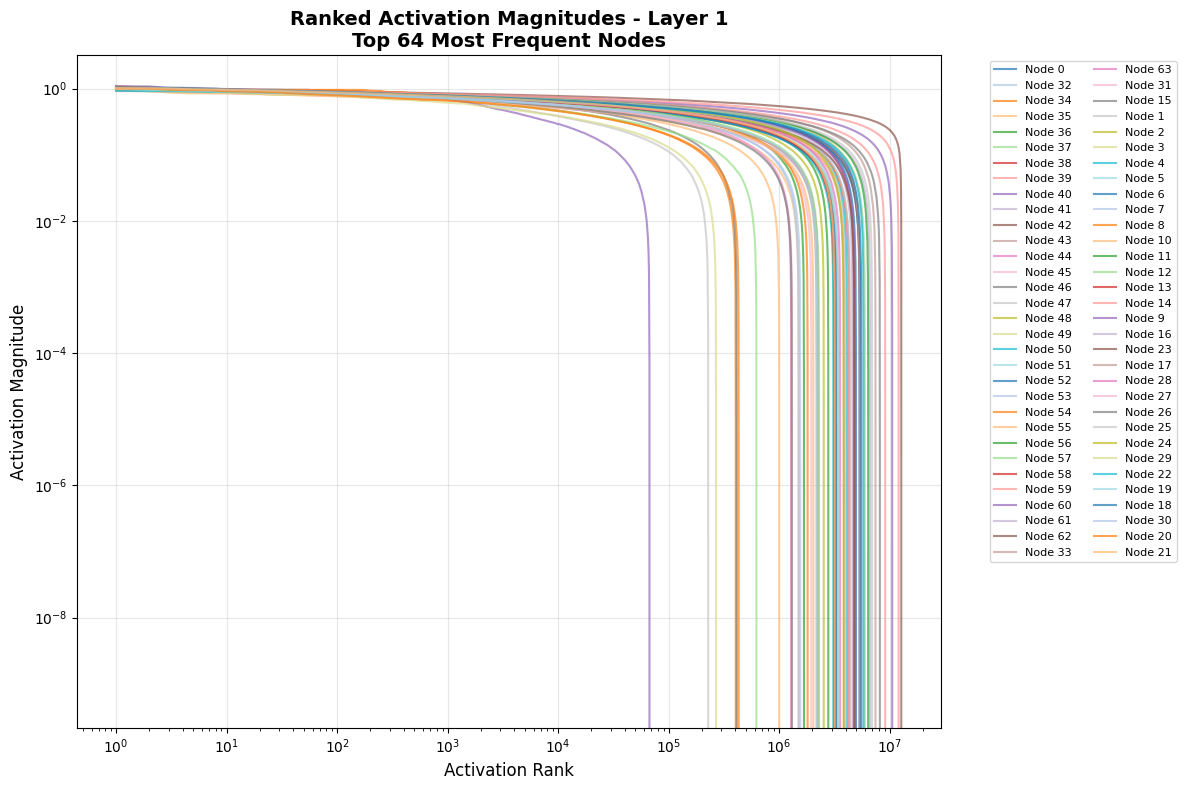


Top 64 nodes - Activation Statistics
Node    0: 12845000 activations, max=1.0395, median=0.0000
Node   32: 12845000 activations, max=0.9561, median=0.0000
Node   34: 12845000 activations, max=0.9937, median=0.0000
Node   35: 12845000 activations, max=1.0000, median=0.0000
Node   36: 12845000 activations, max=1.0483, median=0.0000
Node   37: 12845000 activations, max=1.0142, median=0.0000
Node   38: 12845000 activations, max=1.0580, median=0.0000
Node   39: 12845000 activations, max=1.0178, median=0.1073
Node   40: 12845000 activations, max=1.0356, median=0.1703
Node   41: 12845000 activations, max=0.9940, median=0.0099


In [4]:
from workflow.scripts.pipeline_scripts import plot_position_nodes as plotpos
import numpy as np
import matplotlib.pyplot as plt
import json
import os
from tqdm import tqdm

# ===== NEW: Plot ranked activation magnitudes for top nodes =====

def plot_ranked_node_activations(activations_dir, layer_idx, num_nodes=50, 
                                  max_activations=1000, figsize=(12, 8)):
    """
    Plot ranked activation magnitudes for the top N most frequent nodes.
    
    Parameters
    ----------
    activations_dir : str
        Directory containing activation .npy files and meta.json
    layer_idx : int
        Which layer to analyze
    num_nodes : int
        Number of top nodes to plot
    max_activations : int
        Maximum number of activations to plot per node (for performance)
    figsize : tuple
        Figure size (width, height)
    """
    # Load metadata
    with open(os.path.join(activations_dir, "meta.json")) as f:
        meta = json.load(f)
    
    batch_files = meta["batch_files"]
    latent_dim = meta.get("latent_dim", 256)  # Adjust if stored differently
    
    # Count node activations to find top N
    print(f"Counting activations for layer {layer_idx}...")
    counts = np.zeros(latent_dim, dtype=np.int64)
    for path in tqdm(batch_files, desc="Counting"):
        arr = np.load(path, mmap_mode="r")
        idx = arr[:, layer_idx, :, 0].astype(np.int32)
        counts += np.bincount(idx.ravel(), minlength=latent_dim)
    
    # Get top N nodes by frequency
    top_nodes = np.argsort(counts)[-num_nodes:][::-1]
    
    # Collect all activations for each top node
    print(f"\nCollecting activations for top {num_nodes} nodes...")
    node_activations = {node: [] for node in top_nodes}
    
    for path in tqdm(batch_files, desc="Collecting"):
        arr = np.load(path, mmap_mode="r")
        idx = arr[:, layer_idx, :, 0].astype(np.int32)
        val = np.abs(arr[:, layer_idx, :, 1])
        
        for node in top_nodes:
            mask = (idx == node)
            if mask.any():
                node_activations[node].extend(val[mask].tolist())
    
    # Sort activations for each node (descending) and truncate
    for node in top_nodes:
        acts = sorted(node_activations[node], reverse=True)
        node_activations[node] = acts[:max_activations]
    
    # Plot
    fig, ax = plt.subplots(figsize=figsize)
    
    cmap = plt.get_cmap('tab20')
    colors = [cmap(i % 20) for i in range(num_nodes)]
    
    for idx, node in enumerate(top_nodes):
        acts = node_activations[node]
        ranks = np.arange(1, len(acts) + 1)
        ax.plot(ranks, acts, label=f'Node {node}', 
                alpha=0.7, linewidth=1.5, color=colors[idx])
    
    ax.set_xlabel('Activation Rank', fontsize=12)
    ax.set_ylabel('Activation Magnitude', fontsize=12)
    ax.set_title(f'Ranked Activation Magnitudes - Layer {layer_idx}\n'
                 f'Top {num_nodes} Most Frequent Nodes', 
                 fontsize=14, fontweight='bold')
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.grid(True, alpha=0.3)
    
    # Legend outside plot
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', 
              fontsize=8, ncol=2)
    
    plt.tight_layout()
    plt.show()
    
    # Print statistics
    print(f"\n{'='*70}")
    print(f"Top {num_nodes} nodes - Activation Statistics")
    print(f"{'='*70}")
    for node in top_nodes[:10]:  # Show top 10
        acts = node_activations[node]
        print(f"Node {node:4d}: {len(acts):7d} activations, "
              f"max={max(acts):.4f}, median={np.median(acts):.4f}")

# Run the analysis
out_dir = "/scratch/users/jgalante/SparseNet_Snakemake/results/p53/sae/ef1.0_tf1.0_cl1000"
plot_ranked_node_activations(
    activations_dir=f"{out_dir}/activations",
    layer_idx=1,
    num_nodes=64,
    max_activations=100000000
)

In [ ]:
import numpy as np
import json
import os
from tqdm import tqdm

def analyze_node_sample_coverage(activations_dir, layer_idx, num_nodes=64, 
                                  threshold=1e-4):
    """
    Analyze how many unique samples each node activates on above a threshold.
    
    Parameters
    ----------
    activations_dir : str
        Directory containing activation .npy files and meta.json
    layer_idx : int
        Which layer to analyze
    num_nodes : int
        Number of top nodes to analyze
    threshold : float
        Minimum activation magnitude to count
    """
    # Load metadata
    with open(os.path.join(activations_dir, "meta.json")) as f:
        meta = json.load(f)
    
    batch_files = meta["batch_files"]
    rows_per_locus = meta["rows_per_locus"]
    latent_dim = meta.get("latent_dim", 256)
    
    # Count node activations to find top N
    print(f"Counting activations for layer {layer_idx}...")
    counts = np.zeros(latent_dim, dtype=np.int64)
    for path in tqdm(batch_files, desc="Counting"):
        arr = np.load(path, mmap_mode="r")
        idx = arr[:, layer_idx, :, 0].astype(np.int32)
        counts += np.bincount(idx.ravel(), minlength=latent_dim)
    
    # Get top N nodes by frequency
    top_nodes = np.argsort(counts)[-num_nodes:][::-1]
    
    # Track which samples each node activates on
    print(f"\nAnalyzing sample coverage for top {num_nodes} nodes (threshold={threshold})...")
    node_sample_sets = {node: set() for node in top_nodes}
    
    total_samples = 0
    for batch_idx, path in enumerate(tqdm(batch_files, desc="Processing batches")):
        arr = np.load(path, mmap_mode="r")
        
        # arr shape: (batch_size * rows_per_locus, num_layers, k, 2)
        batch_size = arr.shape[0] // rows_per_locus
        total_samples += batch_size
        
        idx = arr[:, layer_idx, :, 0].astype(np.int32)
        val = np.abs(arr[:, layer_idx, :, 1])
        
        for node in top_nodes:
            # Find where this node is activated above threshold
            mask = (idx == node) & (val > threshold)
            
            if mask.any():
                # Get row indices where node is activated
                activated_rows = np.where(mask.any(axis=1))[0]
                
                # Convert row indices to sample indices
                # Each sample has rows_per_locus rows
                sample_indices = activated_rows // rows_per_locus
                
                # Add global sample indices
                global_sample_indices = batch_idx * batch_size + sample_indices
                node_sample_sets[node].update(global_sample_indices.tolist())
    
    # Print results
    print(f"\n{'='*80}")
    print(f"Sample Coverage Analysis - Layer {layer_idx}")
    print(f"Threshold: {threshold:.2e} | Total samples: {total_samples}")
    print(f"{'='*80}")
    print(f"{'Node':>8} | {'Rank':>4} | {'Samples Active':>14} | {'% Coverage':>12} | {'Total Acts':>12}")
    print(f"{'-'*80}")
    
    results = []
    for rank, node in enumerate(top_nodes):
        num_samples = len(node_sample_sets[node])
        pct_coverage = 100 * num_samples / total_samples
        total_acts = int(counts[node])
        
        results.append({
            'node': node,
            'rank': rank,
            'num_samples': num_samples,
            'pct_coverage': pct_coverage,
            'total_activations': total_acts
        })
        
        print(f"{node:8d} | {rank:4d} | {num_samples:14d} | {pct_coverage:11.2f}% | {total_acts:12d}")
    
    print(f"{'='*80}\n")
    
    # Summary statistics
    sample_counts = [len(node_sample_sets[node]) for node in top_nodes]
    print(f"Summary Statistics:")
    print(f"  Mean samples per node: {np.mean(sample_counts):.1f}")
    print(f"  Median samples per node: {np.median(sample_counts):.1f}")
    print(f"  Min samples: {min(sample_counts)}")
    print(f"  Max samples: {max(sample_counts)}")
    
    return results, node_sample_sets

# Run the analysis
out_dir = "/scratch/users/jgalante/SparseNet_Snakemake/results/p53/sae/ef1.0_tf1.0_cl1000"
results, sample_sets = analyze_node_sample_coverage(
    activations_dir=f"{out_dir}/activations",
    layer_idx=0,
    num_nodes=64,
    threshold=1e-4
)

# Variant Testing

Marginalizing a p53 motif in background sequence motif versus p53 sequences in natural context

Looking at a p53 motif from one sample and mutating each base pair to see how the nodes and magnitudes react
- analyzing to understand diversity of nodes/magnitudes activated with each variant
- i.e. do all of these changes get written into magnitudes in the later layers. are they more indexed in earlier layers

In [ ]:
# I need to take one canonical p53 motif from the samples [CATG CCCGGG ATG]
# I need to change each nucleotide to test 16*4 different inputs
# I want to track, for each of these inputs, the node and magnitude in each of the motif's positions
# I wnat to also track differences in flanking positions

# I then want to take a background sequence and marginalize a p53 sequence
# I want to test if there are differences in node and magnitude when marginalizing versus comparing to samples with that motif

# Okay i couldn't find like any example of the canonical motif that was not in an ERV... which is interesting in itself
# We're going to just : chr3:32364186-32364542
# chr8:71,530,288-71,531,938 (specific from below)
# chr8:68,226,153-72,600,681 (all)

In [ ]:
# After I do this and understand some of the results in a controlled environment
# I want to do the same to ChromBPNet on the sequences used for variant-Effects
# Then can try to make a statement, based on node usage on which sequences might be more biological

# Transposon Testing

In [ ]:
# p53 binding sites come from ERV events - can our network detect which of these are ERVs
# Do these sites look more like marginalized sequences or other...? idk if that question makes sense
# Are these mapping errors?